<a href="https://colab.research.google.com/github/BayMichal/AI_Python/blob/devel/BM_RegressionLogistic_Release_Opt-RPROP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=84e103506adfb6f8c965285fb1aaf74b8a783a603bfa6e67ead9f9d75345c037
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [2]:
pip install hiddenlayer

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import time
from torchviz import make_dot
import hiddenlayer as hl
from collections import Counter

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

projekt="RESNET34"

In [4]:
!mkdir ~/.kaggle #Tworze katalog kaggle w google collab 



In [5]:
#Wrzucam plik do gog colab (usuwa sie po sesji)

! cp /kaggle.json ~/.kaggle/ # kopia pliku do folderu kaagle
#!echo '<"username":"volatille","key":"b06bccd3d1795d29ff0b071f635f2d79">' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  #Ustawienie zgody na dostep

In [6]:
!pip install -q kaggle #Install kaggle

In [7]:
import kaggle

#Ściagam baze danych
!kaggle datasets  download "paultimothymooney/breast-histopathology-images" --force


100% 3.10G/3.10G [00:47<00:00, 26.7MB/s]
100% 3.10G/3.10G [00:47<00:00, 70.6MB/s]


In [8]:
#Rozpakowywuje baze danych, ukrywam output, bo za dużo śmieci
%%capture
!unzip breast-histopathology-images.zip

In [9]:
#Wczesniej wczytywałem poprzez sciezkie w systemie, po migracji na coolab zmieniłem ścieżkę.

data_dir = '../content'
folder_name = "IDC_regular_ps50_idx5"
image_folders = os.path.join(data_dir, folder_name)

transform = transforms.Compose([transforms.Resize((50, 50)), transforms.ToTensor()]) #Funkcja robie resize każdego pliku (50x50) oraz rzutuję na = torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 

zdjecia_idc = []
for file in os.listdir(image_folders):
    zdjecia_idc.append(ImageFolder(os.path.join(image_folders, file), transform=transform)) #pętla, alokacja wczesniej przyjętych zmian dla plików.
datasets = torch.utils.data.ConcatDataset(zdjecia_idc) #upchanie wszystkiego do datasets

In [10]:
#Sprawdzenie poprawnosci Datasets
datasets

In [11]:
from collections import Counter

#Obliczanie ile jest danych w zbiorze (IDC)
j=0
for dataset in tqdm(datasets.datasets):
    if j == 0:
        result = Counter(dataset.targets)
        j += 1
    else:
        result += Counter(dataset.targets)


Pliki_2 = os.listdir(os.path.join(data_dir, folder_name))
print(" \n Liczba Pacjentów:", len(Pliki_2))

print("""\n Liczba zdjęć:
    IDC_0 (Brak IDC)  : {}
    IDC_i (Obecne IDC): {}""".format(result[0], result[1]))




  0%|          | 0/279 [00:00<?, ?it/s]

 
 Liczba Pacjentów: 279

 Liczba zdjęć:
    IDC_0 (Brak IDC)  : 198738
    IDC_i (Obecne IDC): 78786


In [12]:
# Prepare data for training, validation and test
random_seed = 42
torch.manual_seed(random_seed)

test_size = 38000
train_size = len(datasets) - test_size
train_ds, test_ds = random_split(datasets, [train_size, test_size])

val_size = 38000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

len(train_ds), len(val_ds), len(test_ds)

(201524, 38000, 38000)

In [13]:
train_data = DataLoader(train_ds, shuffle=True, num_workers=4, pin_memory=True)
val_data = DataLoader(val_ds, shuffle=True, num_workers=4, pin_memory=True)
test_data = DataLoader(test_ds, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# Save Train, Validation and Test Data
def save_data(data, mode="train"):
    i = 0
    for img, label in data:
        folder_path = os.path.join(os.path.join(os.getcwd(), mode), str(np.array(label)[0]))
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        i += 1
        image = transforms.ToPILImage()(img[0, :, :, :])
        image.save(os.path.join(folder_path, mode+"_"+str(i)+".jpg"), "JPEG")

In [15]:
# Save Train Data
save_data(train_data, mode="train")

# Save Validation Data
save_data(val_data, mode="validation")

# Save Test Data
save_data(test_data, mode="test")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
data = DataLoader(datasets, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
# Transformacja danych /tt.ToTensor
train_tfms = tt.Compose([tt.ToTensor()])
valid_tfms = tt.Compose([tt.ToTensor()])

In [18]:

# Load train, validation and test dataset
data_dir = "../content/"
train_file = os.path.join(data_dir, "train")
val_file = os.path.join(data_dir, "validation")
test_file = os.path.join(data_dir, "test")

train_ds = ImageFolder(train_file, train_tfms)
val_ds = ImageFolder(val_file, valid_tfms)
test_ds = ImageFolder(test_file, valid_tfms)

In [19]:
# Batch Size
batch_size = 1000

#Dane do treningu, validacji oraz testu
#   shuffle=True, przy false może nastąpić większy błąd val_loss (w treningu sieci)
#   pin_memory to wstawka dla conda cpu
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
### Funkcja wskaźnika F1 według algorytmu ###
#   Funkcja jest testem na dokładność. Wartość 1.0 oznacza najwyższą precyzję

#Funkcja oblicza wartości:
# TP = True Positives
# TN = True Negatives
# FP = False Positives
# FN = False Negatives

def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [21]:
#Klasa zawierająca funkcję do kroku treningu modułu, kroku validacji modułu.
# @training_step() zwraca train_loss
# @validation_step() zwraca validation_loss
# @validation_epoch_end() 

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        targets = torch.reshape(targets.type(torch.cuda.FloatTensor), (len(targets), 1))
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch
        targets = torch.reshape(targets.type(torch.cuda.FloatTensor), (len(targets), 1))
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [22]:
class BreastCancerLogisticReg(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return torch.sigmoid(out)

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [25]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
input_size = 50*50*3
model = to_device(BreastCancerLogisticReg(), device)

In [27]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_loss': 0.7784887552261353, 'val_score': 0.28200000524520874}]

In [30]:
#Liczba epok
epochs = 30

#Max learning rate
max_lr = 0.01

#Funkcja optymalizacji ai - RMSprop
opt_func = torch.optim.RMSprop

In [31]:
%%time
start_time = time.time()
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, opt_func=opt_func)

train_time = time.time() - start_time

  0%|          | 0/202 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.0007, train_loss: 1.6520, val_loss: 0.4631, val_score: 0.1465


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0015, train_loss: 1.1016, val_loss: 0.7304, val_score: 0.1403


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0028, train_loss: 17.1424, val_loss: 71.7361, val_score: 0.2824


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0044, train_loss: 71.6162, val_loss: 71.7360, val_score: 0.2824


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0060, train_loss: 71.6256, val_loss: 71.7312, val_score: 0.2824


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0076, train_loss: 55.8950, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0089, train_loss: 28.3804, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0097, train_loss: 28.3696, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0100, train_loss: 28.3741, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0099, train_loss: 28.3638, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.0098, train_loss: 28.3723, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.0095, train_loss: 28.3723, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.0091, train_loss: 28.3737, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.0087, train_loss: 28.3732, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.0081, train_loss: 28.3768, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.0075, train_loss: 28.3750, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.0068, train_loss: 28.3710, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.0061, train_loss: 28.3732, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.0054, train_loss: 28.3777, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.0046, train_loss: 28.3629, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.0039, train_loss: 28.3642, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.0032, train_loss: 28.3651, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.0025, train_loss: 28.3647, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.0019, train_loss: 28.3701, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.0013, train_loss: 28.3687, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.0009, train_loss: 28.3768, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.0005, train_loss: 28.3791, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.0002, train_loss: 28.3638, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.0001, train_loss: 28.3660, val_loss: 28.2447, val_score: 0.0000


  0%|          | 0/202 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.0000, train_loss: 28.3809, val_loss: 28.2447, val_score: 0.0000
CPU times: user 1min 49s, sys: 1min 19s, total: 3min 9s
Wall time: 44min 52s


In [32]:
# Funkcja do pred. danych

@torch.no_grad()
def predict_dl(dl, model, threshold=0.5):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [int(x) for x in batch_probs>threshold]

  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

Model F-Score (Test Data):  0.0
Model F1-Score (Test Data):  0.0
Model Accuracy:  0.7137105263157895
Confusion Matrix:
 [[27121     0]
 [10879     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83     27121
           1       0.00      0.00      0.00     10879

    accuracy                           0.71     38000
   macro avg       0.36      0.50      0.42     38000
weighted avg       0.51      0.71      0.59     38000



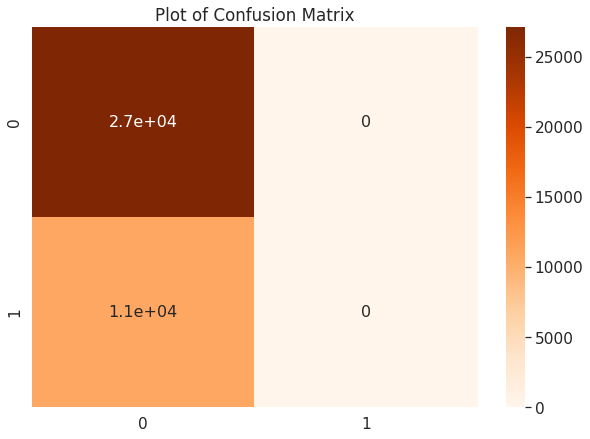

<Figure size 432x288 with 0 Axes>

In [33]:
# Macierz błędu
test_preds = predict_dl(test_dl, model)
actual_label = test_dl.dl.dataset.targets
f1 = f1_score(actual_label, test_preds)
f_score = float(np.array(F_score(torch.tensor(np.array(test_preds).reshape(len(test_preds), 1)), torch.tensor(np.array(actual_label).reshape(len(actual_label), 1)))))
accuracy = accuracy_score(actual_label, test_preds)
cm = confusion_matrix(actual_label, test_preds)
report = classification_report(actual_label, test_preds)

print("Model F-Score (Test Data): ", f_score)
print("Model F1-Score (Test Data): ", f1)
print("Model Accuracy: ", accuracy)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Plot Confusion Matrix
df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Oranges", annot=True, annot_kws={"size": 16})
plt.title("Plot of Confusion Matrix")
plt.show()
plt.savefig("Logistic_Regression_CM_no_aug")